In [ ]:
from collections.abc import Callable
from importlib import reload

import numpy as np
from matplotlib import pyplot as plt
import jax
from jax import numpy as jnp

import base_system
import L96
import solvers
import base_optim

reload(base_system)
reload(L96)
reload(solvers)
reload(base_optim)

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray

In [ ]:
def get_initial_values(system):
    SEED = 42

    I, J, J_sim = system.I, system.J, system.J_sim

    # Initial true state
    init = np.random.default_rng(SEED).uniform(size=I + I * J)

    u0 = jnp.array(init[:I])
    v0 = jnp.array(jnp.reshape(init[I:], (I, J)))

    # Initial simulation state
    un0 = jnp.zeros_like(u0)
    vn0 = jnp.zeros((I, J_sim))

    return (
        jnp.concatenate((jnp.expand_dims(u0, axis=1), v0), axis=1),
        jnp.concatenate((jnp.expand_dims(un0, axis=1), vn0), axis=1),
    )


def run_update(
    system: L96.System,
    solver: solvers.SinglestepSolver,
    dt: float,
    T0: float,
    Tf: float,
    t_relax: float,
    true0: jndarray,
    nudged0: jndarray,
    method: Callable[
        [base_system.System, jndarray, jndarray], jndarray
    ] = base_optim.levenberg_marquardt,
):
    t0 = T0
    tf = t0 + t_relax
    true0, nudged0 = get_initial_values(system)

    cs = [system.cs]

    u_errors = []
    v_errors = []

    while tf <= Tf:
        true, nudged = solver.solve(true0, nudged0, t0, tf, dt)

        true0, nudged0 = true[-1], nudged[-1]

        # Update parameters
        system.cs = method(
            system, true0[system.observed_slice], nudged0
        )
        cs.append(system.cs)

        t0 = tf
        tf = t0 + t_relax

        # Relative error
        u_errors.append(
            np.linalg.norm(true[:, 0] - nudged[:, 0], axis=1)
            / np.linalg.norm(true[:, 0], axis=1)
        )
        v_errors.append(
            np.linalg.norm(true[:, 1:] - nudged[:, 1:], axis=(1, 2))
            / np.linalg.norm(true[:, 1:], axis=(1, 2))
        )

    u_errors = np.concatenate(u_errors)
    v_errors = np.concatenate(v_errors)

    # Note `t0` is the actual final time of the simulation (Tf_actual).
    tls = np.linspace(T0, t0, len(u_errors) + 1)

    return jnp.stack(cs), u_errors, v_errors, tls


def plot(c1s, c2s, u_errors, v_errors, g1, g2, tls):
    num_iters = len(c1s)
    ils = np.arange(num_iters)

    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    ax = axs[0, 0]
    ax.hlines(g1, ils[0], ils[-1], label="g1", color="black")
    ax.plot(ils, c1s, label="c1")
    ax.legend()
    ax.set_title("c1 vs g1")
    ax.set_xlabel("Iteration number")

    ax = axs[0, 1]
    ax.hlines(g2, ils[0], ils[-1], label="g2", color="black")
    ax.plot(ils, c2s, label="c2")
    ax.legend()
    ax.set_title("c2 vs g2")
    ax.set_xlabel("Iteration number")

    ax = axs[1, 0]
    ax.plot(tls[1:], u_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $u$")
    ax.set_xlabel("Time")

    ax = axs[1, 1]
    ax.plot(tls[1:], v_errors)
    ax.set_yscale("log")
    ax.set_title("Relative error in $v$")
    ax.set_xlabel("Time")

    fig.tight_layout()

    return fig, axs

In [ ]:
# Dimensions
I, J = 40, 5
J_sim = J

# System evolution parameters
g1, g2 = 1e-2, 0.5
c1, c2 = g1, g2
c1 *= 0.5
c2 *= 0.5
ds = jnp.array([0.2, 0.5, 1, 2, 5])
F = 8
μ = 50

gs = jnp.array([F, *ds, g1, g2])
bs = jnp.array([F, *ds])
cs = jnp.array([c1, c2])

observed_slice = jnp.s_[:, 0]
system = L96.L96(μ, gs, bs, cs, observed_slice, I, J, J_sim)
solver = solvers.RK4(system)

# Simulation parameters
dt = 0.04
T0, Tf = 0, 1000
t_relax = 1

cs, u_errors, v_errors, tls = run_update(
    system, solver, dt, T0, Tf, t_relax, *get_initial_values(system)
)

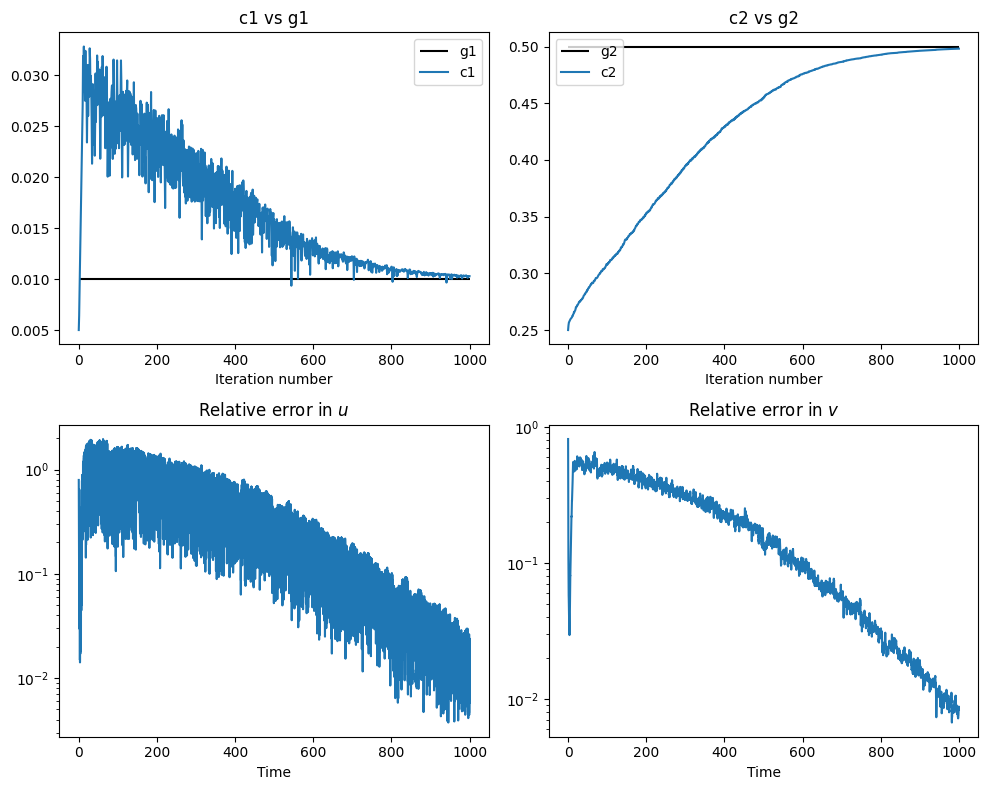

In [ ]:
fig, axs = plot(cs.T[0], cs.T[1], u_errors, v_errors, g1, g2, tls)
plt.show()